## 整脸替换
参考博客：https://www.learnopencv.com/face-swap-using-opencv-c-python/

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 第一步：检测人脸关键点

In [2]:
cas = cv2.CascadeClassifier('./model/haarcascade_frontalface_alt2.xml')
obj = cv2.face.createFacemarkLBF()
obj.loadModel('./model/lbfmodel.yaml')

In [3]:
def detect_facepoint(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(img_gray.shape)
    print(cas.detectMultiScale(img_gray,2,3,0,(30,30)))
    faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
    landmarks = obj.fit(img_gray,faces)
    assert landmarks[0],'no face detected'
    if(len(landmarks[1])>1):
        print('multi face detected,use the first')
    return faces[0],np.squeeze(landmarks[1][0])

In [4]:
def draw_kps(img,face_box,kps,kpssize=3):
    img_show = img.copy()
    cv2.rectangle(img_show,(face_box[0],face_box[1]),(face_box[0]+face_box[2],face_box[1]+face_box[3]),(0,255,0),3)
    for i in range(kps.shape[0]):
        cv2.circle(img_show,(kps[i,0],kps[i,1]),kpssize,(0,0,255),-1)
    img_show = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
    return img_show

## 第二步：人脸凸包三角网格剖分

In [5]:
# 提取人脸外接凸多边形的三角网格
#第五章节https://docs.opencv.org/3.4.9/dd/d49/tutorial_py_contour_features.html
def get_triangle(img,facekpts):
    convex_kps = cv2.convexHull(facekpts,returnPoints=True)
    kps = np.squeeze(convex_kps)
    rect = (0,0,img.shape[1],img.shape[0])
    subdiv = cv2.Subdiv2D(rect)
    for i in range(kps.shape[0]):
        subdiv.insert((kps[i,0],kps[i,1]))
    triangleList = subdiv.getTriangleList()
    return triangleList
#找到三角网格对应的关键点索引
def get_nearest(img_t,face_kps):
    triangle_idx=[]
    for t in img_t:
        idx1=np.argmin(np.sum(abs(face_kps-np.array([[t[0],t[1]]])),axis=1))
        idx2=np.argmin(np.sum(abs(face_kps-np.array([[t[2],t[3]]])),axis=1))
        idx3=np.argmin(np.sum(abs(face_kps-np.array([[t[4],t[5]]])),axis=1))
        triangle_idx.append([idx1,idx2,idx3])
    return triangle_idx

In [6]:
def draw_triangles(img,triangles):
    for t in triangles:
        pt1 = (t[0],t[1])
        pt2 = (t[2],t[3])
        pt3 = (t[4],t[5])
        cv2.line(img,pt1,pt2,(0,255,0),2,cv2.LINE_AA)
        cv2.line(img,pt1,pt3,(0,255,0),2,cv2.LINE_AA)
        cv2.line(img,pt2,pt3,(0,255,0),2,cv2.LINE_AA)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

## 变形
注意是将第二张图的人脸给第一张图，需要找到第一张图的人脸三角网格的关键点索引，然后利用第一张图的每个三角形的索引去切割第二张图，然后把第二张图的每个三角网格变形贴到第一张图的三角网格区域

In [7]:
def applyAffineTransform(src, srcTri, dstTri, size) : 
    # 给定两个三角形，找到第一个到第二个的仿射变换矩阵
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )    
    # 将第一个做仿射变换
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst

In [8]:
def warp_triangle(dst_img,src_img,img_tri1,kps1,kps2):
    # 提取第一张图的所有三角网格对应的人脸关键点索引
    wrap_idx = get_nearest(img_tri1,kps1)
    for i in range(len(wrap_idx)): #将第二个图的每个网格变形贴到第一张图的对应位置
        t1 = kps1[wrap_idx[i]]
        t2 = kps2[wrap_idx[i]]
        patch_rect1 = cv2.boundingRect(t1)
        patch_rect2 = cv2.boundingRect(t2)
        new_t1 = t1 - np.array([[ patch_rect1[0],patch_rect1[1] ]])
        new_t2 = t2 - np.array([[ patch_rect2[0],patch_rect2[1] ]])
        img_patch2 = src_img[patch_rect2[1]:patch_rect2[1]+patch_rect2[3],
          patch_rect2[0]:patch_rect2[0]+patch_rect2[2]]# 提取第二张图的网格图像
        patch_affine2=applyAffineTransform(img_patch2,new_t2,new_t1,(patch_rect1[2],patch_rect1[3])) #变形
        #将第二张图网格变形后贴到第一张图对应地方
        mask = np.zeros((patch_rect1[3],patch_rect1[2],3),dtype=np.uint8)
        mask = cv2.fillConvexPoly(mask,new_t1,(1,1,1),16,0)
        mask_img = patch_affine2*mask
        dst_img[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]] = \
            dst_img[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]]*(1-mask)
        dst_img[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]] = \
            dst_img[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]]+mask_img
    return dst_img

## 测试代码

(540, 540)
[[173 146 160 160]]
(889, 500)
[[178 138 160 160]]


(-0.5, 499.5, 888.5, -0.5)

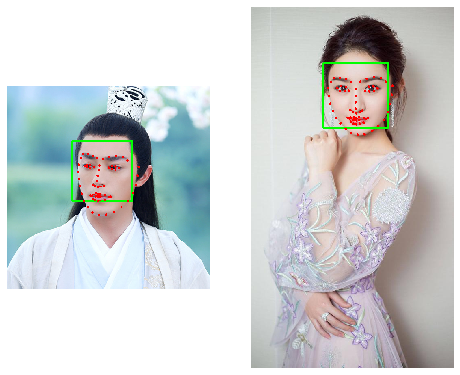

In [9]:
img1 = cv2.imread('./images/hjh.jpg')
img2 = cv2.imread('./images/zly.jpg')
face_box1,face_kps1 = detect_facepoint(img1)
face_kps1=face_kps1.astype(int)
face_box2,face_kps2 = detect_facepoint(img2)
face_kps2=face_kps2.astype(int)
plt.figure(figsize=[8,8])
plt.subplot(121)
plt.imshow(draw_kps(img1,face_box1,face_kps1))
plt.axis('off')
plt.subplot(122)
plt.imshow(draw_kps(img2,face_box2,face_kps2))
plt.axis('off')

In [10]:
img_t1 = get_triangle(img1,face_kps1)
img_t2 = get_triangle(img2,face_kps2)

(-0.5, 499.5, 888.5, -0.5)

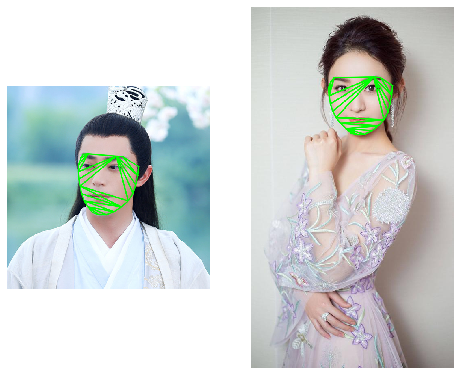

In [11]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(draw_triangles(img1.copy(),img_t1))
plt.axis('off')
plt.subplot(122)
plt.imshow(draw_triangles(img2.copy(),img_t2))
plt.axis('off')

In [12]:
# 对人脸网格进行变形
wrap_img = warp_triangle(img1.copy(),img2.copy(),img_t1,face_kps1,face_kps2)

(-0.5, 539.5, 539.5, -0.5)

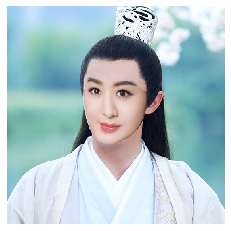

In [13]:
plt.imshow(cv2.cvtColor(wrap_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

In [14]:
# 对人脸进行重新贴图
convex1 = cv2.convexHull(face_kps1,returnPoints=True)
mask = np.zeros_like(img1)
mask = cv2.fillConvexPoly(mask,convex1,(255,255,255))
r=cv2.boundingRect(convex1)
center = ((r[0]+int(r[2]/2)),r[1]+int(r[3]/2))
result_img = cv2.seamlessClone(wrap_img,img1,mask,center,cv2.NORMAL_CLONE)

(-0.5, 539.5, 539.5, -0.5)

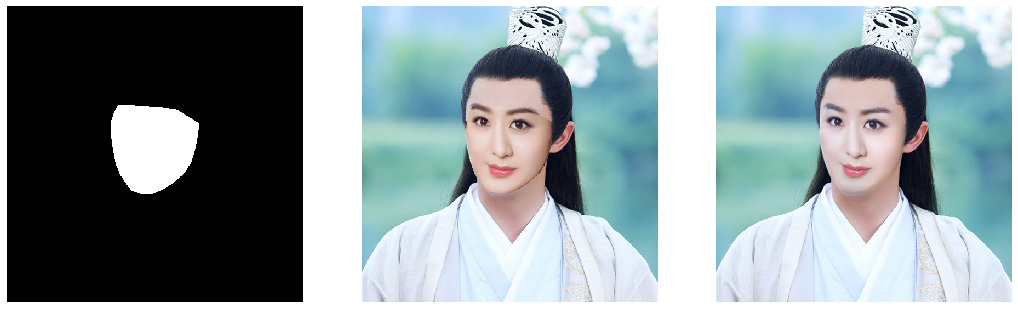

In [15]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.imshow(mask.astype(np.uint8))
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(wrap_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(result_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

## 测试变形
注意是将第二张图的人脸给第一张图，需要找到第一张图的人脸三角网格的关键点索引，然后利用第一张图的每个三角形的索引去切割第二张图，然后把第二张图的每个三角网格变形贴到第一张图的三角网格区域

In [16]:
# 提取第一张图的所有三角网格对应的人脸关键点索引
wrap_idx = get_nearest(img_t1,face_kps1)

In [17]:
i=2
t1 = face_kps1[wrap_idx[i]]
t2 = face_kps2[wrap_idx[i]]
patch_rect1 = cv2.boundingRect(t1)
patch_rect2 = cv2.boundingRect(t2)
new_t1 = t1 - np.array([[ patch_rect1[0],patch_rect1[1] ]])
new_t2 = t2 - np.array([[ patch_rect2[0],patch_rect2[1] ]])

In [18]:
img_patch2 = img2[patch_rect2[1]:patch_rect2[1]+patch_rect2[3],
                  patch_rect2[0]:patch_rect2[0]+patch_rect2[2]]

(-0.5, 499.5, 888.5, -0.5)

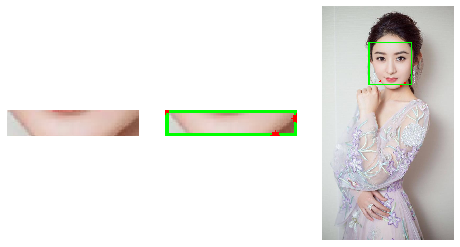

In [19]:
#验证当前关键点是否正确
plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img_patch2.copy(),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(132)
plt.imshow(draw_kps(img_patch2,(0,0,patch_rect2[2],patch_rect2[3]),new_t2))
plt.axis('off')
plt.subplot(133)
plt.imshow(draw_kps(img2.copy(),face_box2,t2,4))
plt.axis('off')

In [20]:
def applyAffineTransform(src, srcTri, dstTri, size) : 
    # 给定两个三角形，找到第一个到第二个的仿射变换矩阵
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )    
    # 将第一个做仿射变换
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst

In [21]:
patch_affine2=applyAffineTransform(img_patch2,new_t2,new_t1,(patch_rect1[2],patch_rect1[3]))

(-0.5, 99.5, 29.5, -0.5)

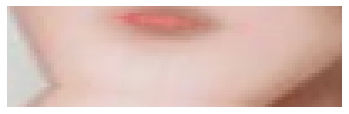

In [22]:
plt.imshow(cv2.cvtColor(patch_affine2.copy(),cv2.COLOR_BGR2RGB))
plt.axis('off')

In [23]:
mask = np.zeros((patch_rect1[3],patch_rect1[2],3),dtype=np.uint8)
mask = cv2.fillConvexPoly(mask,new_t1,(1,1,1),16,0)
mask_img = patch_affine2*mask
img1[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]] = \
    img1[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]]*(1-mask)
img1[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]] = \
    img1[patch_rect1[1]:patch_rect1[1]+patch_rect1[3],patch_rect1[0]:patch_rect1[0]+patch_rect1[2]]+mask_img